In [14]:
import catboost
import numpy as np
import pandas as pd
import os
import sys
from catboost.datasets import adult
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import ColumnTransformer
from data_utils import create_imbalanced_dataset
from data_utils import resample_with_smote

sys.path.insert(0, '..')
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Fetching adult dataset

In [40]:
if os.path.exists('adult_full.csv'):
    adult_full = pd.read_csv('adult_full.csv')
else:
    adult_train, adult_test = adult()
    adult_train.to_csv('adult_train.csv', index=False)
    adult_test.to_csv('adult_test.csv', index=False)
    adult_full = pd.concat([adult_train, adult_test], axis=0)
    adult_full.to_csv('adult_full.csv', index=False)
    
adult_full.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39.0,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K


In [41]:
lb = LabelBinarizer()
y = adult_full['income']
y = lb.fit_transform(y)
X = adult_full.drop('income', axis=1)


In [42]:

numeric_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
numeric_transformer = StandardScaler()

categorical_features = ['education', 'marital-status', 'native-country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
categorical_transformer = TargetEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

X = preprocessor.fit_transform(X, y)

/Users/broniyasinnik/PycharmProjects/bigdata/ml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



# Create artificial imbalance

In [49]:
ir = 200
imb_data = create_imbalanced_dataset(X, y, ir)
x_imb = imb_data["X_imb"]
y_imb = imb_data["y_imb"]
x_drop = imb_data["X_drop"]
y_drop = imb_data["y_drop"]
X_train, X_test, y_train, y_test = train_test_split(x_imb, y_imb, test_size=0.2, stratify=y_imb, random_state=42)


In [50]:
print("Shape X train:", X_train.shape, " Num minority:", y_train.sum())
print("Shape X test:", X_test.shape, " Num minority:", y_test.sum())
print("Shape X dropped:", x_drop.shape, " Num minority:", y_drop.sum())
print("IR train is:", (y_train==0).sum()/(y_train==1).sum())
print("IR test is:", (y_test==0).sum()/(y_test==1).sum())

Shape X train: (29872, 14)  Num minority: 148
Shape X test: (7468, 14)  Num minority: 37
Shape X dropped: (11502, 14)  Num minority: 11502
IR train is: 200.83783783783784
IR test is: 200.83783783783784


In [51]:
np.savez(f"./ir{ir}/adult_ir{ir}.tra.npz", X=X_train, y=y_train)
np.savez(f"./ir{ir}/adult_ir{ir}.tst.npz", X=X_test, y=y_test)
np.savez(f"./ir{ir}/adult_ir{ir}.hout.npz", X=x_drop, y=y_drop)

In [52]:
resample_with_smote(f"./ir{ir}/adult_ir{ir}.tra.npz")

In [94]:
from scipy.stats import describe
describe(X_train)

DescribeResult(nobs=30318, minmax=(array([-1.57862888e+00, -1.66825021e+00, -3.53102982e+00, -1.44803531e-01,
       -2.17127099e-01, -3.18145213e+00,  1.20481928e-02,  4.54799280e-02,
        3.40909091e-02,  1.23966942e-02,  1.17021277e-01,  1.46418678e-02,
        1.09251482e-01,  2.95260720e-05]), array([ 3.74580818, 12.31723105,  2.30339745, 13.27438165, 10.59179446,
        4.72731162,  0.73980815,  0.44613253,  0.42105263,  0.47781794,
        0.26925609,  0.46889747,  0.30376723,  0.55339233])), mean=array([-0.12197922,  0.00387337, -0.16898232, -0.1162181 , -0.07627659,
       -0.11652415,  0.20983354,  0.19442063,  0.23725293,  0.21281108,
        0.23687915,  0.19322219,  0.22912523,  0.23181235]), variance=array([1.04883314, 1.02203414, 0.90142969, 0.07384563, 0.63591372,
       0.99954889, 0.01726079, 0.03336263, 0.00189666, 0.01989126,
       0.00205577, 0.03419024, 0.00894791, 0.00461523]), skewness=array([ 0.74118145,  1.49785203, -0.41324402, 34.71303296,  5.80445811,


# Results

In [4]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt

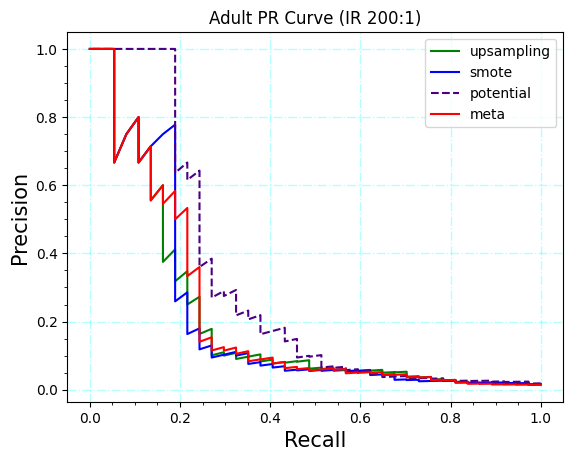

In [9]:
ir = 200
pr_up = pd.read_csv(f'./ir{ir}/logs/upsampling/results/pr.csv')
pr_smote = pd.read_csv(f'./ir{ir}/logs/smote/results/pr.csv')
pr_poten = pd.read_csv(f'./ir{ir}/logs/potential/results/pr.csv')
pr_meta = pd.read_csv(f'./ir{ir}/logs/meta/results/pr.csv')
plt.plot(pr_up['recall'], pr_up['precision'], label='upsampling', color='green')
plt.plot(pr_smote['recall'], pr_smote['precision'], label='smote', color='blue')
plt.plot(pr_poten['recall'], pr_poten['precision'], label='potential', linestyle='--', color='Indigo')
plt.plot(pr_meta['recall'], pr_meta['precision'], label='meta', color='red')
plt.xlabel('Recall', fontsize=15)
plt.ylabel('Precision', fontsize=15)
plt.minorticks_on()
plt.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=1)
plt.title(f"Adult PR Curve (IR {ir}:1)")
plt.legend()
plt.show()

In [29]:
import glob
import re
from collections import defaultdict

result_files = glob.glob(f'./*/logs/*/results/pr.csv')
pattern = re.compile('\./(?P<data_name>.*?)/logs/(?P<experiment_name>.*?)/results/pr\.csv')
d = defaultdict(dict)
for path in result_files:
    m = re.match(pattern, path)
    data_name = m.group('data_name')
    exper_name = m.group('experiment_name')
    print(f'Experiment on Adult {data_name} with {exper_name}')
    df = pd.read_csv(path)
    df.sort_values(by='recall', ascending=False)
    pr_val = df[df["recall"]>=0.25].tail(1)['precision'].values[0]
    d[exper_name][data_name] = pr_val
#     print(df.head(10))
#     break
print(d)

Experiment on Adult ir50 with downsampling
Experiment on Adult ir50 with smote
Experiment on Adult ir50 with meta
Experiment on Adult ir50 with potential
Experiment on Adult ir50 with upsampling
Experiment on Adult ir100 with downsampling
Experiment on Adult ir100 with smote
Experiment on Adult ir100 with meta
Experiment on Adult ir100 with potential
Experiment on Adult ir100 with upsampling
Experiment on Adult ir200 with downsampling
Experiment on Adult ir200 with smote
Experiment on Adult ir200 with meta
Experiment on Adult ir200 with potential
Experiment on Adult ir200 with upsampling
defaultdict(<class 'dict'>, {'downsampling': {'ir50': 0.5135135135135135, 'ir100': 0.4418604651162791, 'ir200': 0.3125}, 'smote': {'ir50': 0.4691358024691358, 'ir100': 0.40425531914893614, 'ir200': 0.12987012987012986}, 'meta': {'ir50': 0.5588235294117647, 'ir100': 0.4130434782608696, 'ir200': 0.15384615384615385}, 'potential': {'ir50': 0.6785714285714286, 'ir100': 0.7916666666666666, 'ir200': 0.384615

In [32]:
import json
result_files = glob.glob(f'./*/logs/*/results/metrics.json')
pattern = re.compile('\./(?P<data_name>.*?)/logs/(?P<experiment_name>.*?)/results/metrics\.json')
records = []
for path in result_files:
    m = re.match(pattern, path)
    data_name = m.group('data_name')
    exper_name = m.group('experiment_name')
    with open(path) as f:
        res = json.load(f)
        records.append((data_name, exper_name, res['average_precision']))

df = pd.DataFrame.from_records(records, columns=['dataset', 'experiment', 'ap'])
df = df.pivot(index='dataset', columns='experiment', values='ap')
df

experiment,downsampling,meta,potential,smote,upsampling
dataset,,,,,
ir100,0.308394,0.333720,0.374926,0.289798,0.310713
ir200,0.224410,0.214286,0.300237,0.208440,0.204549
ir50,0.333668,0.348535,0.406871,0.312797,0.328996


In [47]:
import sklearn
result_files = glob.glob(f'./*/logs/*/results/predictions.csv')
pattern = re.compile('\./(?P<data_name>.*?)/logs/(?P<experiment_name>.*?)/results/predictions\.csv')
d_mcc = defaultdict(dict)
d_kapa = defaultdict(dict)

for path in result_files:
    m = re.match(pattern, path)
    data_name = m.group('data_name')
    exper_name = m.group('experiment_name')
    print(f'Experiment on Adult {data_name} with {exper_name}')
    df = pd.read_csv(path)
    th = 0.8
    df['scores'] = 1*(df['scores']>=th)
    mcc = sklearn.metrics.matthews_corrcoef(df['labels'], df['scores'])
    kapa = sklearn.metrics.cohen_kappa_score(df['labels'], df['scores'])
    d_mcc[exper_name][data_name] = mcc
    d_kapa[exper_name][data_name] = kapa
#     print(val)
#     print(df.head(10))
#     break
d_mcc

Experiment on Adult ir50 with downsampling
Experiment on Adult ir50 with smote
Experiment on Adult ir50 with meta
Experiment on Adult ir50 with potential
Experiment on Adult ir50 with upsampling
Experiment on Adult ir100 with downsampling
Experiment on Adult ir100 with smote
Experiment on Adult ir100 with meta
Experiment on Adult ir100 with potential
Experiment on Adult ir100 with upsampling
Experiment on Adult ir200 with downsampling
Experiment on Adult ir200 with smote
Experiment on Adult ir200 with meta
Experiment on Adult ir200 with potential
Experiment on Adult ir200 with upsampling


defaultdict(dict,
            {'downsampling': {'ir50': 0.28125006457399765,
              'ir100': 0.229136424808902,
              'ir200': 0.17440687143834754},
             'smote': {'ir50': 0.27778699064391194,
              'ir100': 0.22215266685583895,
              'ir200': 0.1611463543677007},
             'meta': {'ir50': 0.34247424457039094,
              'ir100': 0.39237473587776117,
              'ir200': 0.26723722751838525},
             'potential': {'ir50': 0.3746548701233048,
              'ir100': 0.36285912352477906,
              'ir200': 0.23948206406543804},
             'upsampling': {'ir50': 0.2865335565588291,
              'ir100': 0.20931176496768128,
              'ir200': 0.1644216222425388}})

# Embeddings

In [76]:
from datasets import TableDataset

tr = TableDataset.from_npz(['./ir100/adult_ir100.tra.npz', './ir100/adult_ir100.hout.npz'])
tst = TableDataset.from_npz('./ir100/adult_ir100.tst.npz')
smt = TableDataset.from_npz('./ir100/adult_ir100.smt.npz')
hout = TableDataset.from_npz('./ir100/adult_ir100.hout.npz')


In [44]:
tst.target.numpy()

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [36]:
from visualization_utils import projection

projection(data = {'tst': tst, 'hout':hout}, logdir='./ir100')

../visualization_utils.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.cat([torch.tensor(tb.data) for tb in data.values()])


In [38]:
projection(data = {'tst': tst, 'smt':smt}, logdir='./ir100', name='proj-tst-smt')

../visualization_utils.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.cat([torch.tensor(tb.data) for tb in data.values()])


In [39]:
projection(data = {'tst': tst}, logdir='./ir100', name='proj-tst')

Text(0.5, 1.0, 'PCA of IRIS dataset')

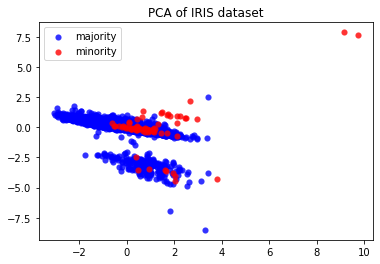

In [82]:
from sklearn import decomposition 
import matplotlib.pyplot as plt

pca = decomposition.PCA(n_components=2)
pca.fit(tr.data.numpy())
X = pca.transform(tst.data.numpy())
y =tst.target.numpy()

x_smt = pca.transform(smt.data.numpy())[:300]
y_smt = smt.target.numpy()[:300]

x_hout = pca.transform(hout.data.numpy())[:300]
y_hout = hout.target.numpy()[:300]

plt.figure()
colors = ['blue', 'red']
lw = 0.1
target_names = ['majority', 'minority']

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='blue', alpha=.8, lw=lw,
                label='majority')
# plt.scatter(x_smt[y_smt == 1, 0], x_smt[y_smt == 1, 1], color='green', alpha=0.8, lw=lw,
#                 label='smote')
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='red', alpha=.8, lw=lw,
                label='minority')

# plt.scatter(x_hout[y_hout == 1, 0], x_hout[y_hout == 1, 1], color='pink', alpha=0.8, lw=lw,
#                 label='smote')

plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of Adult dataset')


In [50]:
y

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)